In [90]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader

from sklearn.preprocessing import StandardScaler    
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix, classification_report
import utils
from tqdm.notebook import tqdm

In [91]:
CI02 = utils.load_data("data/for_learning_plus/CI02.npy")
CI04 = utils.load_data("data/for_learning_plus/CI04.npy")
CI06 = utils.load_data("data/for_learning_plus/CI06.npy")
CI09 = utils.load_data("data/for_learning_plus/CI09.npy")
CI21 = utils.load_data("data/for_learning_plus/CI21.npy")

In [92]:
C1_06 = CI06[CI06['Y']==1]
C1_04 = CI04[CI04['Y']==1]
C1_09 = CI09[CI09['Y']==1]
C1_21 = CI21[CI21['Y']==1]

C0_06 = CI06[CI06['Y']==0]
C0_04 = CI04[CI04['Y']==0]
C0_09 = CI09[CI09['Y']==0]
C0_21 = CI21[CI21['Y']==0]

nb_c1_06 = np.shape(C1_06)[0]
nb_c1_04 = np.shape(C1_04)[0]
nb_c1_09 = np.shape(C1_09)[0]
nb_c1_21 = np.shape(C1_21)[0]

C0_06_eq = C0_06.sample(nb_c1_06)
C0_04_eq = C0_04.sample(nb_c1_04)
C0_09_eq = C0_09.sample(nb_c1_09)
C0_21_eq = C0_21.sample(nb_c1_21)

data_train = pd.concat((C0_06_eq,C1_06,C0_04_eq,C1_04,C0_09_eq,C1_09,C0_21_eq,C1_21))

In [93]:
#data_train = pd.concat((CI04,CI06,CI09,CI21))
data_test = CI02

<AxesSubplot:xlabel='Y', ylabel='count'>

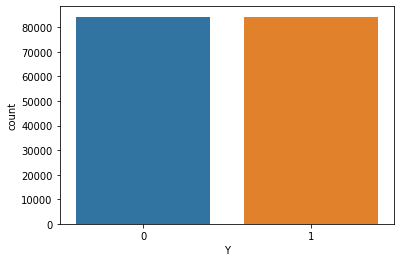

In [94]:
sns.countplot(x ='Y',data=data_train)

In [95]:
X_train = data_train.iloc[:, 1:15]
y_train = data_train.iloc[:, 0]
X_test = data_test.iloc[:, 1:15]
y_test = data_test.iloc[:, 0]

In [96]:
scaler = StandardScaler()
X_train = scaler.fit_transform(X_train)
X_test = scaler.transform(X_test)

In [97]:
EPOCHS = 30
BATCH_SIZE = 64
LEARNING_RATE = 0.001

In [98]:
## train dataclass TrainData(Dataset):
class TrainData(Dataset):

    def __init__(self, X_data, y_data):
        self.X_data = X_data
        self.y_data = y_data
        
    def __getitem__(self, index):
        return self.X_data[index], self.y_data[index]
        
    def __len__ (self):
        return len(self.X_data)


train_data = TrainData(torch.FloatTensor(X_train),torch.FloatTensor(np.array(y_train)))

## test data    class TestData(Dataset):

class TestData(Dataset):  
    def __init__(self, X_data):
        self.X_data = X_data
        
    def __getitem__(self, index):
        return self.X_data[index]
        
    def __len__ (self):
        return len(self.X_data)
    

test_data = TestData(torch.FloatTensor(X_test))

In [99]:
train_loader = DataLoader(dataset=train_data, batch_size=BATCH_SIZE, shuffle=True)
test_loader = DataLoader(dataset=test_data, batch_size=1)

In [100]:
class BinaryClassification(nn.Module):
    def __init__(self):
        super(BinaryClassification, self).__init__()        # Number of input features is 14.
        self.layer_1 = nn.Linear(14, 128) 
        self.layer_2 = nn.Linear(128, 128)
        self.layer_out = nn.Linear(128, 1) 
        
        self.relu = nn.ReLU()
        self.dropout = nn.Dropout(p=0.1)
        self.batchnorm1 = nn.BatchNorm1d(128)
        self.batchnorm2 = nn.BatchNorm1d(128)
        
    def forward(self, inputs):
        x = self.relu(self.layer_1(inputs))
        x = self.batchnorm1(x)
        x = self.dropout(x)
        x = self.relu(self.layer_2(x))
        x = self.batchnorm2(x)
        x = self.dropout(x)
        x = self.layer_out(x)
        
        return x

In [101]:
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
print(device)

cpu


In [102]:
model = BinaryClassification()
model.to(device)
print(model)
criterion = nn.BCEWithLogitsLoss()
optimizer = optim.Adam(model.parameters(), lr=LEARNING_RATE)

BinaryClassification(
  (layer_1): Linear(in_features=14, out_features=128, bias=True)
  (layer_2): Linear(in_features=128, out_features=128, bias=True)
  (layer_out): Linear(in_features=128, out_features=1, bias=True)
  (relu): ReLU()
  (dropout): Dropout(p=0.1, inplace=False)
  (batchnorm1): BatchNorm1d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (batchnorm2): BatchNorm1d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
)


In [103]:
def binary_acc(y_pred, y_test):
    y_pred_tag = torch.round(torch.sigmoid(y_pred))

    correct_results_sum = (y_pred_tag == y_test).sum().float()
    acc = correct_results_sum/y_test.shape[0]
    acc = torch.round(acc * 100)
    
    return acc

In [104]:
def binary_rec(y_pred, y_test):
    y_pred_tag = torch.round(torch.sigmoid(y_pred))

    cm = torch.zeros(2, 2)
    for t, p in zip(y_test.long(), y_pred_tag.long()):
        cm[t, p] += 1

    rec = cm[1,1] / (cm[1,1] + cm[1,0])
    rec = torch.round(rec * 100)
    
    return rec

In [105]:
def binary_spec(y_pred, y_test):
    y_pred_tag = torch.round(torch.sigmoid(y_pred))
    
    cm = torch.zeros(2, 2)
    for t, p in zip(y_test.long(), y_pred_tag.long()):
        cm[t, p] += 1

    spec = cm[0,0] / (cm[0,0] + cm[0,1])
    spec = torch.round(spec * 100)
    
    return spec

In [ ]:
loss_c = []
acc_train_c = []
acc_test_c = []
rec_train_c = []
rec_test_c = []
spec_train_c = []
spec_test_c = []

for e in tqdm(range(1, EPOCHS+1)):
    model.train()
    epoch_loss = 0
    epoch_acc = 0
    epoch_rec = 0
    epoch_spec = 0
    for X_batch, y_batch in tqdm(train_loader):
        X_batch, y_batch = X_batch.to(device), y_batch.to(device)
        optimizer.zero_grad()
        
        y_pred = model(X_batch)
        
        loss = criterion(y_pred, y_batch.unsqueeze(1))
        acc = binary_acc(y_pred, y_batch.unsqueeze(1))
        rec = binary_rec(y_pred, y_batch.unsqueeze(1))
        spec = binary_spec(y_pred, y_batch.unsqueeze(1))
        
        
        loss.backward()
        optimizer.step()
        
        epoch_loss += loss.item()
        epoch_acc += acc.item()
        epoch_rec += rec.item()
        epoch_spec += spec.item()

    loss_c.append(epoch_loss/len(train_loader))
    acc_train_c.append(epoch_acc/len(train_loader))
    rec_train_c.append(epoch_rec/len(train_loader))
    spec_train_c.append(epoch_spec/len(train_loader))

    print(f'Epoch {e+0:03}: | Loss: {epoch_loss/len(train_loader):.5f} | Acc: {epoch_acc/len(train_loader):.3f} | Rec: {epoch_rec/len(train_loader):.3f} | Spec: {epoch_spec/len(train_loader):.3f}')

    y_pred_list = []

    model.eval()
    with torch.no_grad():
        for X_batch in tqdm(test_loader):
            X_batch = X_batch.to(device)
            y_test_pred = model(X_batch)
            y_test_pred = torch.sigmoid(y_test_pred)
            y_pred_tag = torch.round(y_test_pred)
            y_pred_list.append(y_pred_tag.cpu().numpy())
            
    y_pred_list = [a.squeeze().tolist() for a in y_pred_list]

    cm = confusion_matrix(y_test, y_pred_list)

    acc_test_c.append((cm[0,0]+cm[1,1])/sum(sum(cm)))
    rec_test_c.append((cm[1,1] / (cm[1,1] + cm[1,0])))
    spec_test_c.append((cm[0,0] / (cm[0,0] + cm[0,1])))

In [107]:
y_pred_list = []

model.eval()
with torch.no_grad():
    for X_batch in tqdm(test_loader):
        X_batch = X_batch.to(device)
        y_test_pred = model(X_batch)
        y_test_pred = torch.sigmoid(y_test_pred)
        y_pred_tag = torch.round(y_test_pred)
        y_pred_list.append(y_pred_tag.cpu().numpy())
        
y_pred_list = [a.squeeze().tolist() for a in y_pred_list]

  0%|          | 0/255840 [00:00<?, ?it/s]

In [108]:
cm = confusion_matrix(y_test, y_pred_list)
cm

array([[207760,  36631],
       [  6625,   4824]])

In [109]:
cm

array([[207760,  36631],
       [  6625,   4824]])

In [110]:
print(classification_report(y_test, y_pred_list))

              precision    recall  f1-score   support

           0       0.97      0.85      0.91    244391
           1       0.12      0.42      0.18     11449

    accuracy                           0.83    255840
   macro avg       0.54      0.64      0.54    255840
weighted avg       0.93      0.83      0.87    255840



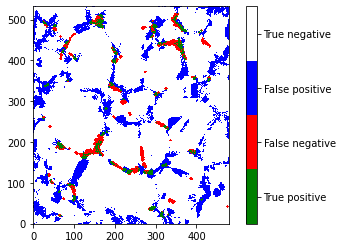

In [111]:
y_val = CI02['Y'] 
im_shape = np.shape(np.load("data/for_learning/CI02.npy"))
utils.plot_pred_proj(y_pred_list,y_val,im_shape)


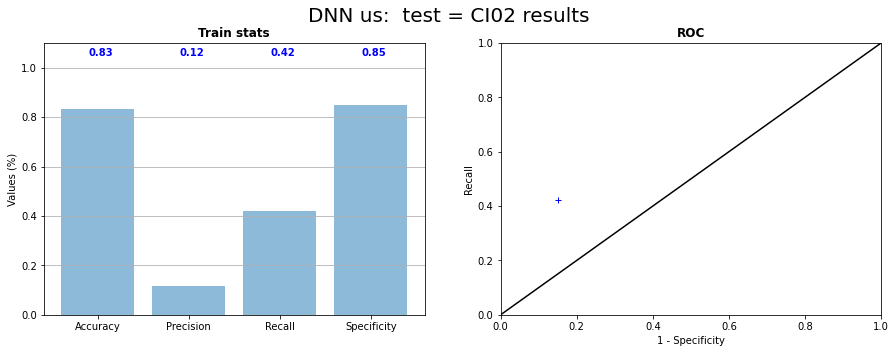

In [112]:
from sklearn import metrics
acc = metrics.accuracy_score(y_val, y_pred_list)
prec = metrics.precision_score(y_val, y_pred_list)
rec = metrics.recall_score(y_val, y_pred_list)
cm = metrics.confusion_matrix(y_val, y_pred_list)
spec = cm[0,0] / (cm[0,0] + cm[0,1])
utils.plot_lstats(acc,prec,rec,spec,model="DNN us:  test = CI02")

In [113]:
data_test = CI04
X_test = data_test.iloc[:, 1:15]
y_test = data_test.iloc[:, 0]
X_test = scaler.transform(X_test)
test_data = TestData(torch.FloatTensor(X_test))
test_loader = DataLoader(dataset=test_data, batch_size=1)

In [114]:
y_pred_list = []

model.eval()
with torch.no_grad():
    for X_batch in tqdm(test_loader):
        X_batch = X_batch.to(device)
        y_test_pred = model(X_batch)
        y_test_pred = torch.sigmoid(y_test_pred)
        y_pred_tag = torch.round(y_test_pred)
        y_pred_list.append(y_pred_tag.cpu().numpy())
        
y_pred_list = [a.squeeze().tolist() for a in y_pred_list]

  0%|          | 0/295836 [00:00<?, ?it/s]

In [115]:
cm = confusion_matrix(y_test, y_pred_list)
cm

array([[233607,  31976],
       [  1619,  28634]])

In [116]:
print(classification_report(y_test, y_pred_list))

              precision    recall  f1-score   support

           0       0.99      0.88      0.93    265583
           1       0.47      0.95      0.63     30253

    accuracy                           0.89    295836
   macro avg       0.73      0.91      0.78    295836
weighted avg       0.94      0.89      0.90    295836



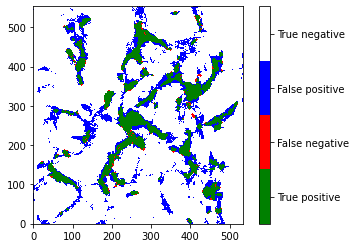

In [117]:
y_val = CI04['Y'] 
im_shape = np.shape(np.load("data/for_learning/CI04.npy"))
utils.plot_pred_proj(y_pred_list,y_val,im_shape)

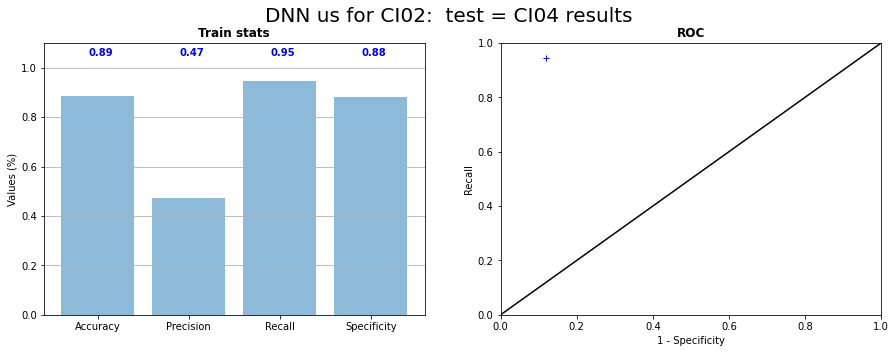

In [118]:
acc = metrics.accuracy_score(y_val, y_pred_list)
prec = metrics.precision_score(y_val, y_pred_list)
rec = metrics.recall_score(y_val, y_pred_list)
cm = metrics.confusion_matrix(y_val, y_pred_list)
spec = cm[0,0] / (cm[0,0] + cm[0,1])
utils.plot_lstats(acc,prec,rec,spec,model="DNN us for CI02:  test = CI04")

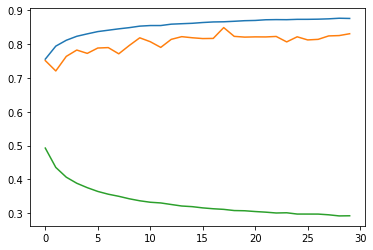

In [129]:
x = np.arange(len(rec_test_c))

plt.plot(x,np.array(acc_train_c)/100)
plt.plot(x,acc_test_c)
plt.plot(x,loss_c)

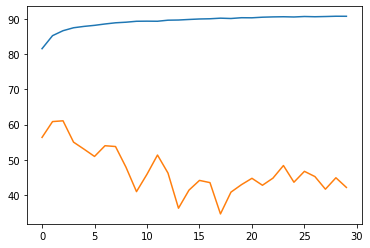

In [130]:
x = np.arange(len(rec_test_c))
plt.plot(x,rec_train_c)
plt.plot(x,np.array(rec_test_c)*100)

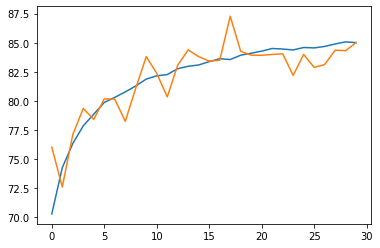

In [131]:
x = np.arange(len(rec_test_c))
plt.plot(x,spec_train_c)
plt.plot(x,np.array(spec_test_c)*100)